This is the notebook I use to parse from wikipedia dumps into structured data, and to reconcile multiple data sources together. It is intended to be explicatory, not reproducible, and might break when re-run.

In [1]:
import wikiparser
import cPickle as pickle
import random

%load_ext autoreload
%autoreload 2

First, build a list of candidate populations based on wikipedia articles that have a population box.

In [ ]:
cache = []
wtf = []
last_print = 0
parser = wikiparser.WikipediaParser("/home/bschmidt/sources/enwiki-20180301-pages-articles-multistream.xml.bz2")
#parser = wikiparser.WikipediaParser("/Users/bschmidt/Downloads/Unconfirmed 628142.crdownload")
for i,article in enumerate(parser):
    if i - last_print >= 100000:
        print "{} cities in {} articles".format(len(cache),i)
        last_print = i
    try:
        pops = article.pops()
        cache.append(article)
        if (len(cache) % 1000 == 0) and i - last_print > 25000:
            last_print = i
            print "{} cities in {} articles".format(len(cache),i)
        if "York City" in article.title:
            # For debugging. Sometimes I was missinig New York.
            print (i, article.title)            
    except wikiparser.NoSuchAttribute:
        continue

In [ ]:
raw = [(article.title,article.id,article.text) for article in cache]
pickle.dump(raw,open("cache_raw_2018.pickle","w"))

In 2017, I had these

In [ ]:
raw = pickle.load(open("cache_raw.pickle"))

In [ ]:
subset = [wikiparser.WikipediaArticle(*args) for args in raw]
random.shuffle(subset)
print len(subset)

In 2018, there are several thousand more.

In [2]:
raw = pickle.load(open("cache_raw_2018.pickle"))
subset = [wikiparser.WikipediaArticle(*args) for args in raw]
random.shuffle(subset)
print len(subset)

53953


In [4]:
subset[233]

Kapelln
{{Infobox Town AT|
      <text xml:space="preserve">{{Infobox Town AT|
name=Kapelln|
name_local=|
image_coa = AUT Kapelln COA.jpg |
image_map = |
state = [[Lower Austria]] |
regbzk = |
district = [[Sankt Pölten-Land]]|
population =1280|
population_as_of = 2001|
population_ref =|
pop_dens = |
area = 20.18|
elevation = 226
|
coordinates = {{coord|48|15|N|15|45|E|display=inline,title}}
|
lat_hem=N|
lon_hem=E|
postal_code = 3141|
area_code =02784|
mayor = Alois Vogl|
website = http://www.kapelln.at

In [7]:
# "Spring Garden, PA" is a problem: ignored as a neighborhood, but actually useful

for i,s in enumerate(subset):
    if s.country() is None and not s.drop_from_title():
        print s.title
        


Upper Canada
Little Bolton
Kosovo
***:Kosovo|display=inline,title}}
| ***
Catholic Church in Canada
Oppland
Jordan River (Utah)
Rural Municipality of St. Andrews
Arabian Peninsula
Germans in the Czech Republic
Rail transport in China
Transperth Trains
{{Xb|K
***:{{Xb|KOS}}|display=inline,title}***
MTR
Rural Municipality of St. Clements
{{Xb|K
***:{{Xb|KOS}}|display=inline,title}***
Taipei Metro
Stone Town
Germans of Kazakhstan
Nordland
Plymouth Colony
Bernstein im Burgenland
High-speed rail in Turkey
Census in Myanmar
Crown Colony of Sarawak
Spain_
***:Spain_type:city|display=title,in***
Timeline of Cape Town
Australian Public Service
Douglas, Juneau
Religion in Canada
Syria
Rape of Bramber
Union Station (Erie, Pennsylvania)
Southwark, Philadelphia
Current Island, Newfoundland
Armstrong's Point
River Heights, Winnipeg
Street dogs in Sofia
Byzantine army
Priesthood in the Catholic Church
Buskerud
{{Xb|K
***:{{Xb|KOS}}|display=inline,title}***
Buddhism in Canada
Mendota Mental Health Ins

In [8]:
int("A")

ValueError: invalid literal for int() with base 10: 'A'

In [42]:
from collections import Counter

countries = Counter()

for i,article in enumerate(subset):
    countries[article.country()] += 1
        
print countries.most_common(10)


[('US', 31675), ('FR', 16754), ('Unknown (Non-US)', 1491), ('CA', 836), ('AT', 754), (None, 498), ('RO', 250), ('ES', 178), ('RS', 149), ('Ireland', 140)]


In [43]:
from collections import Counter

settlements = Counter()

for i,article in enumerate(subset):
    if article.country() == "US":
        settlements[wikiparser.settle_type(article)] += 1
        
for (k,v) in settlements.most_common(50):
    print k, v



Hopkinton, Rhode Island
City 9863
Town 6469
Village 3787
Township 3256
US County 2982
Census-designated place 1397
Borough 1162
Cdp 571
Unknown 337
Unincorporated community 260
 147
Neighborhood 104
Statutory town 100
Home rule municipality 77
County 75
Community area}} 61
General law city 52
Census designated place 51
US State 51
Charter city 43
Census Area 41
Independent city 38
Plantation 37
Ghost town 32
Census-designated place (cdp) &amp; unincorporated community 27
Military Installation 27
Census-designated place (cdp) 26
Unorganized territory 22
Former cdp 22
Charter township 22
Community 21
Municipality 19
State capital 18
&quot;gr1&quot;&gt;publisher=[[united states census bureau|accessdate=2011-04-23|date=2011-02-12|title=us gazetteer files: 2010, 2000, and 1990}} 15
Census-designated place &amp; unincorporated community 13
Consolidated city-county 13
town 13
Second-class township 11
Hamlet 11
Former census-designated place 10
Metropolitan statistical area 10
NHRP 9
Suburban 

In [162]:
rows = []
failures = []
import numpy as np
years = range(1790,2020,10)

for i,article in enumerate(subset):
    if i % 1000 == 0:
        print i
    if article.country() not in ["US","USA","United States","United States of America"]:
        continue
    if article.drop_from_title():
        continue
    out = {"title":article.title,"id":article.id}
    try:
        pops = article.pops()
    except wikiparser.NoSuchAttribute:
        print "No pops for {}".format(article.title)
        failures.append(article)
        continue
    try:
        out["state"] = article.state()
    except wikiparser.NoSuchAttribute:
        if article.pops():
            if article.pops()[-1][1] > 100000:
                raise
                failures.append(article)
    except KeyError as exception:
        if 'unorganized, unincorporated territory' in str(exception).lower():
            continue
        if 'plainlist' in str(exception):
            # Some multi-state metro areas
            continue
        else:
            raise
    try:
        out["lat"],out["lon"] = article.coords()
    except:
        out["lat"], out["lon"] = [None,None]
    out["settlement_type"] = wikiparser.settle_type(article)
    try:
        out["poptype"] = str(article.poptype)
    except:
        out["poptype"] = "Unknown"
    for year in years:
        out['y' + str(year)] = 0
    try:
        out['other_years'] = "["
        for year,population in article.pops():
            year = 'y' + str(year)
            if year in out: # Only store for census years
                if population == 0:
                    population=np.nan
                out[year] = population
            else:
                out['other_years'] += "[{},{}],".format(year,population)
        # Drop the final comma
        out['other_years'] = out['other_years'][:-1]
        # add a closing bar if anything was put here.
        if (out['other_years'] != ""):
            out['other_years'] += "]"
    except TypeError:
        print "No pops for {}".format(article.title)
        #failures.append(article)
        continue
    out["article_length"] = len(article.text)
    out["country"] = article.country()
    rows.append(out)

print article.title

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
SOMETHING OFF WITH Hopkinton, Rhode Island
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
La Flotte


In [159]:
print article.text

{{other uses}}
      <text xml:space="preserve">{{other uses}}
{{Refimprove|date=April 2015}}
The '''Pee Dee''' region of [[South Carolina]] is the northeastern corner of the state. The main [[area code]] is 843. It is the area of the lower watershed of the [[Pee Dee River]], named after the [[Pee Dee (tribe)|Pee Dee]] [[Native Americans in the United States|Native American]] tribe that occupies this area. They are descended from a culture of the same name that occupied the area as part of the South Appalachian Mississippian Culture, from about 1000 to 1400, leaving some centers for unknown reasons. The official seat of government for the Pee Dee Indian Tribe is now located in Marlboro County. They are a state recognized tribe who have been seeking federal acknowledgment since 1976. 

The region's 21st-century center is [[Florence, South Carolina|Florence]]. It encompasses the [[Grand Strand]], which includes the beaches running from the [[North Carolina]] state border to the [[Winyah 

Code used to debug settlement type. Fiddled with until I was getting > 99% extraction rate.

In [163]:
for j in range(100):
    f = random.sample(subset,1)[0]
    if f.drop_from_title():
        continue
    #print f.text[:500]
    for i in range(10):
        if f.country() != "US":
            f = random.sample(subset,1)[0]
    _ = wikiparser.settle_type(f)
    if _ == "Unknown":
        print j
        print f.title
        print f.text[:2500]
        raise
print  j

99


What are some places that have no state listed in them?

In [164]:
for f in subset:
    if f.drop_from_title():
        continue
    if f.country() != "US":
        continue
    try:
        _ = f.state()
    except wikiparser.NoSuchAttribute:
        p = f.pops()
        try:
            # Only print big places.
            if p[-1][1] < 1000: 
                continue
        except:
            pass
        print '"{}":"",'.format(f.title)
        #print f.text[:2500]


"Fort Wainwright":"",
"Woodlawn (Birmingham)":"",
"McChord Field":"",
"Tuscarora Reservation":"",
"Grissom Air Reserve Base":"",
"Fort Lewis":"",
"Fort Leonard Wood":"",
"Fort McClellan":"",
"Andrews Air Force Base":"",
"Minot Air Force Base":"",
"Camden County High School (Georgia)":"",
"Shekhan District":"",
"Grosse Pointe":"",
"Eielson Air Force Base":"",
"Nellis Air Force Base":"",
"Ensley (Birmingham)":"",
"Beale Air Force Base":"",
"Louds Island":"",
"K. I. Sawyer Air Force Base":"",
"Louisiana State University":"",
"Edwards Air Force Base":"",
"Joint Base Andrews":"",
"Tribeca":"",
"Fort Carson":"",
"Kentucky State University":"",
"Greater Grand Forks":"",
"Tyndall Air Force Base":"",
"McGuire Air Force Base":"",
"Oil Springs Reservation":"",
"Mountain Home Air Force Base":"",
"Johnstown Inclined Plane":"",
"Vint Hill Farms Station":"",
"Fairchild Air Force Base":"",
"Fort Richardson (Alaska)":"",
"Dover Air Force Base":"",
"Redstone Arsenal":"",
"St. Regis Mohawk Reservation":"

This data is written out to separate files for each state to make it easier to merge with Jacob Alperin's data.

In [166]:
# A list of state names
import provinces
import pandas as pd
import os


frame = pd.DataFrame(rows)
from ggplot import *
if not os.path.exists("wikipedia_state_data"):
    os.makedirs("wikipedia_state_data")
for k,v in provinces.us_states.iteritems():
    frame[frame.state==v].to_csv("wikipedia_state_data/{}.csv".format(v))

frame.to_csv("wiki3.csv")

In [ ]:
#frame = frame[frame.poptype=="USA" ]

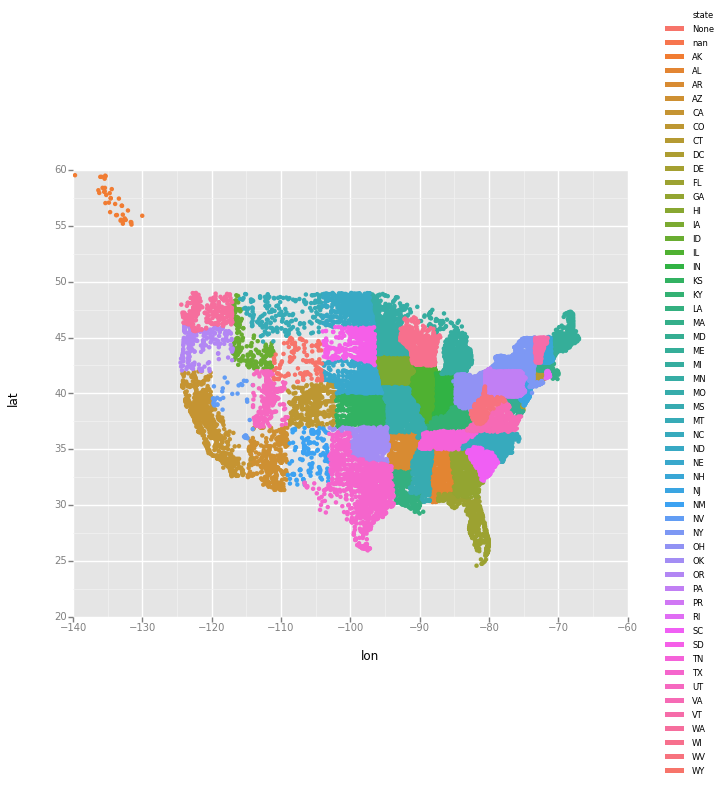

<ggplot: (8770827287017)>

In [96]:
ggplot(frame[frame.lon < -25],aes(x="lon",y="lat",color="state")) + geom_point() + ylim(20,60) + xlim(-140,-60)

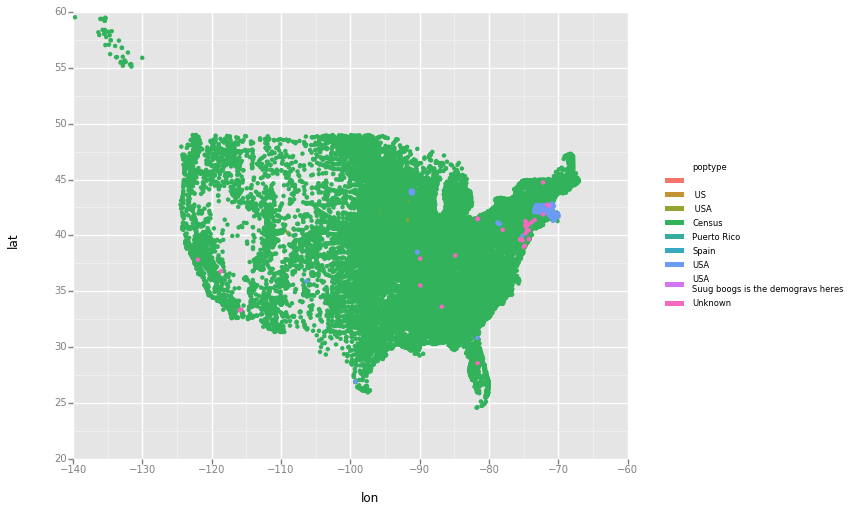

<ggplot: (8770824927673)>

In [97]:
ggplot(frame[frame.lon < -25],aes(x="lon",y="lat",color="poptype")) + geom_point() + ylim(20,60) + xlim(-140,-60)

Matching on values

In [ ]:
import numpy as np
array = np.array(frame[["y" + str(y) for y in years]],np.float64)
array[array==0] = np.nan

In [ ]:
all_matches = []

for i in range(len(array)):
    p = array[i:-1]==array[i+1:]
    matches = np.where(np.sum(p,axis=1)>2)
    if len(matches[0]) > 0:
        print i
        all_matches.append((i,matches))
    if i % 5000 == 0:
        print i
                       
                       


In [ ]:
c1 = pd.read_csv("wiki_census/MEPlaces.csv")
c1["2010"] = pd.to_numeric(c1["2010"],np.float64)
maine = np.array(c1[[str(y) for y in years]])

# (202) 224-3121

def match_row(a,b,i,min=3):
    l = np.where(np.sum(a == b[i],axis=1)>min)[0]
    if len(l) > 0:
        return list(l)
    
def match_matrices(a,b,min=3):
    matches = []
    for i in range(len(b)):
        row_matches = match_row(a,b,i,min=min)
        matches.append((i,row_matches))
    return matches
fah = match_matrices(array,maine)
fah[:4]

In [ ]:
CESTA = pd.read_csv("../MiscData/CESTACityData.csv")
CESTA["2010"] = pd.to_numeric(CESTA["2010"],np.float64)
c_mat = np.array(CESTA[[str(y) for y in years]])
#c_mat[c_mat < 2500] = np.nan
c_mat[c_mat==0] = np.nan


In [ ]:
altered_array = array.clip(2500)

cesta_crosswalk = match_matrices(array,c_mat)

In [ ]:
j = 0
misses = []
for i,matches in cesta_crosswalk:
    if matches is None:
        if c_mat[i][19] > 0:
            misses.append(i)
            j += 1
            print j,i,CESTA.iloc[i]["CityST"], ", ".join([str(int(p)) for p in list(c_mat[i]) if not np.isnan(p)])
            f = c_mat[0]


In [ ]:
print len(misses)
random.seed(3)
sampled = random.sample(misses,10)

In [ ]:
i = sampled[0]
place, pops = CESTA.iloc[i]["CityST"], ", ".join([str(int(p)) if not np.isnan(p) else "0" for p in list(c_mat[i])])
print place,"--", pops

print frame[frame.title=="Brunswick, Maine"]

So after digging around, it seems that CESTA reports statistics for the Brunswick CDP, (but rounded to the nearest 100?), while Wikipedia gives the statistics for Brunswick Town. The difference being a second CDP,   https://en.wikipedia.org/wiki/Brunswick_Station,_Maine

In [ ]:
i = sampled[1]
place, pops = CESTA.iloc[i]["CityST"], ", ".join([str(int(p)) if not np.isnan(p) else "0" for p in list(c_mat[i])])
print place,"--", pops

print frame[frame.title=="Lakewood Township, New Jersey"]

In [ ]:
CESTA = pd.read_csv("../MiscData/CESTACityData.csv")
CESTA["2010"] = pd.to_numeric(CESTA["2010"],np.float64)
c_mat = np.array(CESTA[[str(y) for y in years]])
c_mat[c_mat < 2500] = np.nan
c_mat[c_mat==0] = np.nan


In [ ]:
print sum(sum(c_mat>0))
print sum(sum(array>0))

Now I want to load the data from the wikipedia editor DemocraticLuntz, which is not the same as the full wikipedia set.

In [ ]:
import os
fs = [f for f in os.listdir("wiki_census/") if f.endswith(".csv")]
fs.sort()
print fs
print """
There are multiple files for some places. I use the longer one, because it has more populations entered in.
(Inspecting differences makes this clear.)
"""

master_list = []
last = "XXf"
for f in fs:
    if f[:2]!=last[:2]:
        master_list.append(f)
    else:
        # which is bigger?
        if os.path.getsize("wiki_census/" + master_list[-1]) > os.path.getsize("wiki_census/" +f):
            continue
        else:
            continue
    last = f
print master_list

In [ ]:
all_together = pd.DataFrame([])
for f in master_list:
    new_data = pd.read_csv("wiki_census/" + f,na_values = ["-","(X)"," "])
    new_data["state"] = f[:2]
    all_together = all_together.append(new_data)

year_frame = all_together[[str(y) for y in years]]
for y in years:
    # God I hate pandas because I don't know every
    pass
    #year_frame[str(y)] = pd.to_numeric(year_frame[str(y)])
jacob_mat = np.array(year_frame[[str(y) for y in years]])
jacob_mat[jacob_mat==0] = np.nan


In [ ]:
sum(sum(jacob_mat>0))

There's a straightforward disagreement in at least this one case.

In [ ]:
a = frame[frame["title"]=="Princeton, Indiana"].index[0]
b = CESTA[CESTA.CityST == "Princeton, IN"].index[0]
zip(
    list(array[a]),
    list(c_mat[b])
)

Indana.gov says:
    6,041	6,448	7,132	7,505	7,786	7,673	7,906	7,431	8,976	8,127	8,175	8,644
    
IOW, agrees with the CESTA data.
So does the Census report.
So does jacobmas's data. It seems this is an anonymous wikipedia editor in 2007, who put in 
[an absurdly high current population](https://en.wikipedia.org/w/index.php?title=Princeton,_Indiana&diff=187475063&oldid=183213818) and just a whole bunch of bad (made-up?) numbers from before.'
|1850= 806
|1860= 1397
|1870= 1847
|1880= 2566
|1890= 3076
|1900= 6041
|1910= 6448
|1920= 7132
|1930= 7505
|1940= 7786
|1950= 7673
|1960= 7906
|1970= 7431
|1980= 8976
|1990= 8127
|2000= 8175
|2010= 8644
|2020= 8608


Save to disk

Confirm that requiring at least 3 matches produces no hash collisions

In [ ]:
c_self = match_matrices(c_mat,c_mat,2)

In [ ]:
for row,matches in c_self:
    try:
        if len(matches) != 1:
            print row,matches
    except:
        continue

It does not. The only collision is lines 1 and 2, because the Lahnmeyer data rounds to 100 for Alaskan towns. 8227 and 570 are both Lake Elsinore, CA. 

In [ ]:
CESTA.iloc[8227]

In [ ]:
total_pop = [(title,sum([p for (y,p) in pops]), pops[-2][1], length) for title,pops,length in older]
import pandas as pd
total_pop.sort(key = lambda x: x[1],reverse=True)
frame = pd.DataFrame(total_pop,columns=["title","total","last","length"])
frame.to_csv("city_pops.csv")

In [ ]:
import random
import shelve

def keyer(x):
    return len(x[1])
older.sort(key = keyer,reverse=True)
[(o[0],len(o[1])) for o in older[:25]]

In [ ]:
import random
import shelve

def keyer(x):
    return len(x[1])
older.sort(key = keyer,reverse=True)
[(o[0],len(o[1])) for o in older[:25]]

In [ ]:
[(c[0],c[1]) for c in older if c[0]=="Connecticut"]

In [ ]:
[a.title for a in cache if "Brooklyn" in a.title]

In [ ]:
foo = wikiparser.WikipediaArticle("London")

In [ ]:
import mwparserfromhell

In [ ]:
self = wikiparser.WikipediaArticle("Chicago")

In [ ]:
foo.mwparse()

In [ ]:
import random
random.sample(cache,1)[0].historical_pops()